<a href="https://colab.research.google.com/github/abxda/geobigdata-inegi-colab/blob/main/GeoBigData_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Maquina Virtual

In [1]:
!lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.6 LTS
Release:	18.04
Codename:	bionic


In [2]:
!lscpu | grep -E '^Model name|^Thread|^Core|^Socket|^CPU\('

CPU(s):              2
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz


In [ ]:
!free -m -h

              total        used        free      shared  buff/cache   available
Mem:            12G        859M          9G        1.2M        1.9G         11G
Swap:            0B          0B          0B


In [ ]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         108G   39G   70G  36% /
tmpfs            64M     0   64M   0% /dev
shm             5.8G     0  5.8G   0% /dev/shm
/dev/root       2.0G  1.1G  910M  54% /sbin/docker-init
tmpfs           6.4G   40K  6.4G   1% /var/colab
/dev/sda1        55G   40G   16G  72% /etc/hosts
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive           108G   42G   66G  39% /content/drive


In [ ]:
!lsblk -d -o name,rota

NAME  ROTA
loop0    0
sda      0


Instalación de Requerimientos

In [4]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.2/spark-3.2.2-bin-hadoop3.2.tgz
!tar xf spark-3.2.2-bin-hadoop3.2.tgz
!pip -q install findspark

In [5]:
! java -version

openjdk version "11.0.16" 2022-07-19
OpenJDK Runtime Environment (build 11.0.16+8-post-Ubuntu-0ubuntu118.04)
OpenJDK 64-Bit Server VM (build 11.0.16+8-post-Ubuntu-0ubuntu118.04, mixed mode, sharing)


In [6]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.2-bin-hadoop3.2"

In [7]:
!pip -q install pyspark

     |████████████████████████████████| 281.3 MB 38 kB/s 
     |████████████████████████████████| 199 kB 58.4 MB/s 


In [8]:
!pip -q install geopandas attrs shapely rtree apache-sedona[spark]

     |████████████████████████████████| 1.0 MB 5.2 MB/s 
     |████████████████████████████████| 1.0 MB 45.1 MB/s 
     |████████████████████████████████| 67 kB 3.8 MB/s 
     |████████████████████████████████| 6.3 MB 38.5 MB/s 
     |████████████████████████████████| 16.7 MB 662 kB/s 


Descarga de Bases de Datos Listas para el Análisis

In [3]:
#Descarga de Bases de Datos SCINCE 2020 y DENUE Mayo 2022
#DENUE: https://drive.google.com/file/d/1CbCm0n41uKHPi-L8bTag2G6RA71tdaM4/view?usp=sharing
!gdown 1CbCm0n41uKHPi-L8bTag2G6RA71tdaM4
#SCINCE:https://drive.google.com/file/d/134WppiiO8fdYOxD4yJI-ZX51YTwnVgLu/view?usp=sharing
!gdown 134WppiiO8fdYOxD4yJI-ZX51YTwnVgLu

Downloading...
From: https://drive.google.com/uc?id=1CbCm0n41uKHPi-L8bTag2G6RA71tdaM4
To: /content/DENUE_Parquets.zip
100% 486M/486M [00:02<00:00, 186MB/s]
Downloading...
From: https://drive.google.com/uc?id=134WppiiO8fdYOxD4yJI-ZX51YTwnVgLu
To: /content/SCINCE_Parquets.zip
100% 1.14G/1.14G [00:06<00:00, 183MB/s]


Descompactar los Datos

In [9]:
!ls /content/*.zip

/content/DENUE_Parquets.zip  /content/SCINCE_Parquets.zip


In [10]:
!unzip /content/DENUE_Parquets.zip -d /content/DENUE_Parquets/ &> /dev/null

In [11]:
!unzip /content/SCINCE_Parquets.zip -d /content/SCINCE_Parquets/ &> /dev/null

In [12]:
!ls /content/DENUE_Parquets

01.parquet  07.parquet	13.parquet    18.parquet  24.parquet  30.parquet
02.parquet  08.parquet	14.parquet    19.parquet  25.parquet  31.parquet
03.parquet  09.parquet	15_1.parquet  20.parquet  26.parquet  32.parquet
04.parquet  10.parquet	15_2.parquet  21.parquet  27.parquet
05.parquet  11.parquet	16.parquet    22.parquet  28.parquet
06.parquet  12.parquet	17.parquet    23.parquet  29.parquet


Inicio de Apache Spark y Apache Sedona

In [13]:
import findspark
findspark.init()
import shapely
import pandas as pd 
import geopandas as gpd
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark import SparkConf
from sedona.register import SedonaRegistrator
from sedona.utils import SedonaKryoRegistrator, KryoSerializer
spark = SparkSession. \
builder. \
appName('GeoBigData'). \
config("spark.serializer", KryoSerializer.getName). \
config("spark.executor.memory", "5g"). \
config("spark.driver.memory", "10g"). \
config('spark.driver.maxResultSize', '5g'). \
config("spark.kryo.registrator", SedonaKryoRegistrator.getName). \
config('spark.jars.packages',
           'org.apache.sedona:sedona-python-adapter-3.0_2.12:1.2.0-incubating,'
           'org.datasyslab:geotools-wrapper:1.1.0-25.2'). \
getOrCreate()
SedonaRegistrator.registerAll(spark)

True

Leer Datos

In [14]:
BD_MANZANAS = spark.read.parquet(f"/content/SCINCE_Parquets/01_AGS.parquet")
BD_MANZANAS_EEVVV = BD_MANZANAS.select('CVEGEO', 'ECO1_R', 'EDU46_R', 'VIV82_R', 'VIV83_R', 'VIV84_R', 'geometry')
BD_MANZANAS_EEVVV.cache()
BD_MANZANAS_EEVVV.printSchema()
BD_MANZANAS_EEVVV.show()

root
 |-- CVEGEO: string (nullable = true)
 |-- ECO1_R: double (nullable = true)
 |-- EDU46_R: double (nullable = true)
 |-- VIV82_R: double (nullable = true)
 |-- VIV83_R: double (nullable = true)
 |-- VIV84_R: double (nullable = true)
 |-- geometry: geometry (nullable = true)

+----------------+------+-------+-------+-------+-------+--------------------+
|          CVEGEO|ECO1_R|EDU46_R|VIV82_R|VIV83_R|VIV84_R|            geometry|
+----------------+------+-------+-------+-------+-------+--------------------+
|0100100010017003|  75.8|    8.5|   54.5|    9.1|    9.1|POLYGON ((2473557...|
|010010001006A012|  63.2|   94.1|   33.3|   77.8|   55.6|POLYGON ((2471329...|
|0100100010106028|  79.2|   80.0|   -6.0|   70.0|   -6.0|POLYGON ((2472153...|
|0100100010106034|  73.9|   57.9|   53.3|   40.0|   40.0|POLYGON ((2472128...|
|0100100010106036|  82.3|   64.7|   18.8|   59.4|   31.3|POLYGON ((2472142...|
|0100100010106041|  76.7|   67.9|   41.2|   58.8|   17.6|POLYGON ((2472138...|
|01001000

In [15]:
BD_MANZANAS_EEVVV.createOrReplaceTempView("manzanas")

In [16]:
BD_MZA_EEVVV_CORREGIDO = spark.sql("""select 
                                  CVEGEO,
                                  if( (isnull(ECO1_R) or ECO1_R < 0 ), 0, ECO1_R) as ECO1_R, 
                                  if( (isnull(EDU46_R) or EDU46_R < 0 ), 0, EDU46_R) as EDU46_R,
                                  if( (isnull(VIV82_R) or VIV82_R < 0 ), 0, VIV82_R) as VIV82_R,
                                  if( (isnull(VIV83_R) or VIV83_R < 0 ), 0, VIV83_R) as VIV83_R,
                                  if( (isnull(VIV84_R) or VIV84_R < 0 ), 0, VIV84_R) as VIV84_R,                                  
                                  geometry
                             from manzanas """)

BD_MZA_EEVVV_CORREGIDO.cache()
BD_MZA_EEVVV_CORREGIDO.show()

+----------------+------+-------+-------+-------+-------+--------------------+
|          CVEGEO|ECO1_R|EDU46_R|VIV82_R|VIV83_R|VIV84_R|            geometry|
+----------------+------+-------+-------+-------+-------+--------------------+
|0100100010017003|  75.8|    8.5|   54.5|    9.1|    9.1|POLYGON ((2473557...|
|010010001006A012|  63.2|   94.1|   33.3|   77.8|   55.6|POLYGON ((2471329...|
|0100100010106028|  79.2|   80.0|    0.0|   70.0|    0.0|POLYGON ((2472153...|
|0100100010106034|  73.9|   57.9|   53.3|   40.0|   40.0|POLYGON ((2472128...|
|0100100010106036|  82.3|   64.7|   18.8|   59.4|   31.3|POLYGON ((2472142...|
|0100100010106041|  76.7|   67.9|   41.2|   58.8|   17.6|POLYGON ((2472138...|
|0100100010163017|  79.1|   49.0|   53.7|   48.1|   46.3|POLYGON ((2476783...|
|0100100010163018|  77.1|   31.4|   48.6|   37.8|   32.4|POLYGON ((2476734...|
|0100100010163019|  80.3|   23.6|   50.0|   41.2|   29.4|POLYGON ((2476842...|
|0100100010163031|   0.0|    0.0|    0.0|    0.0|   

In [17]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

vecAssembler = VectorAssembler(inputCols=["ECO1_R", "EDU46_R", "VIV82_R", "VIV83_R", "VIV84_R"], outputCol="features")
BD_MZA_EEVVV_CORREGIDO_VEC = vecAssembler.transform(BD_MZA_EEVVV_CORREGIDO)
BD_MZA_EEVVV_CORREGIDO_VEC.cache()
BD_MZA_EEVVV_CORREGIDO_VEC.show()

+----------------+------+-------+-------+-------+-------+--------------------+--------------------+
|          CVEGEO|ECO1_R|EDU46_R|VIV82_R|VIV83_R|VIV84_R|            geometry|            features|
+----------------+------+-------+-------+-------+-------+--------------------+--------------------+
|0100100010017003|  75.8|    8.5|   54.5|    9.1|    9.1|POLYGON ((2473557...|[75.8,8.5,54.5,9....|
|010010001006A012|  63.2|   94.1|   33.3|   77.8|   55.6|POLYGON ((2471329...|[63.2,94.1,33.3,7...|
|0100100010106028|  79.2|   80.0|    0.0|   70.0|    0.0|POLYGON ((2472153...|[79.2,80.0,0.0,70...|
|0100100010106034|  73.9|   57.9|   53.3|   40.0|   40.0|POLYGON ((2472128...|[73.9,57.9,53.3,4...|
|0100100010106036|  82.3|   64.7|   18.8|   59.4|   31.3|POLYGON ((2472142...|[82.3,64.7,18.8,5...|
|0100100010106041|  76.7|   67.9|   41.2|   58.8|   17.6|POLYGON ((2472138...|[76.7,67.9,41.2,5...|
|0100100010163017|  79.1|   49.0|   53.7|   48.1|   46.3|POLYGON ((2476783...|[79.1,49.0,53.7,4...|


In [18]:
kmeans = KMeans(k=5, seed=1, maxIter=250) 
model = kmeans.fit(BD_MZA_EEVVV_CORREGIDO_VEC.select('features'))
transformed = model.transform(BD_MZA_EEVVV_CORREGIDO_VEC)
transformed.show()

+----------------+------+-------+-------+-------+-------+--------------------+--------------------+----------+
|          CVEGEO|ECO1_R|EDU46_R|VIV82_R|VIV83_R|VIV84_R|            geometry|            features|prediction|
+----------------+------+-------+-------+-------+-------+--------------------+--------------------+----------+
|0100100010017003|  75.8|    8.5|   54.5|    9.1|    9.1|POLYGON ((2473557...|[75.8,8.5,54.5,9....|         0|
|010010001006A012|  63.2|   94.1|   33.3|   77.8|   55.6|POLYGON ((2471329...|[63.2,94.1,33.3,7...|         4|
|0100100010106028|  79.2|   80.0|    0.0|   70.0|    0.0|POLYGON ((2472153...|[79.2,80.0,0.0,70...|         4|
|0100100010106034|  73.9|   57.9|   53.3|   40.0|   40.0|POLYGON ((2472128...|[73.9,57.9,53.3,4...|         3|
|0100100010106036|  82.3|   64.7|   18.8|   59.4|   31.3|POLYGON ((2472142...|[82.3,64.7,18.8,5...|         4|
|0100100010106041|  76.7|   67.9|   41.2|   58.8|   17.6|POLYGON ((2472138...|[76.7,67.9,41.2,5...|         4|
|

In [19]:
transformed.createOrReplaceTempView("result_kmeans")
clusters = spark.sql(""" select prediction, 
    mean(ECO1_R) as mean_econ_activa, 
    mean(EDU46_R) as mean_educ_superior,
    mean(VIV82_R) as mean_tv_paga,
    mean(VIV83_R) as mean_streaming,
    mean(VIV84_R) as mean_videojuegos,
    count(*) as conteo
from result_kmeans group by prediction order by mean_econ_activa""")

clusters.show()

+----------+------------------+------------------+-----------------+------------------+------------------+------+
|prediction|  mean_econ_activa|mean_educ_superior|     mean_tv_paga|    mean_streaming|  mean_videojuegos|conteo|
+----------+------------------+------------------+-----------------+------------------+------------------+------+
|         1|0.2682119205298013|0.1504139072847682|              0.0| 0.138658940397351|               0.0|  2416|
|         2| 62.73140096618356| 7.567720685111992|7.817171717171719| 2.066842336407554|1.9887571365832233|  2277|
|         0| 63.51451104100954| 11.63544256819446|46.81521618110969|11.329374652069019|  9.34215995546482|  5389|
|         3| 64.12663452847242|  41.5147634829769|55.10735161193131| 35.40518228382049|21.083639650497112|  3319|
|         4| 66.60604512558534|  73.4247765006385| 61.3858663260962| 68.24312473392935| 38.85329927628778|  2349|
+----------+------------------+------------------+-----------------+------------------+-

In [20]:
df_clusters = clusters.toPandas()

In [21]:
df_clusters

,prediction,mean_econ_activa,mean_educ_superior,mean_tv_paga,mean_streaming,mean_videojuegos,conteo
0,1,0.268212,0.150414,0.000000,0.138659,0.000000,2416
1,2,62.731401,7.567721,7.817172,2.066842,1.988757,2277
2,0,63.514511,11.635443,46.815216,11.329375,9.342160,5389
3,3,64.126635,41.514763,55.107352,35.405182,21.083640,3319
4,4,66.606045,73.424777,61.385866,68.243125,38.853299,2349


In [22]:
import numpy as np
import matplotlib.pyplot as plt

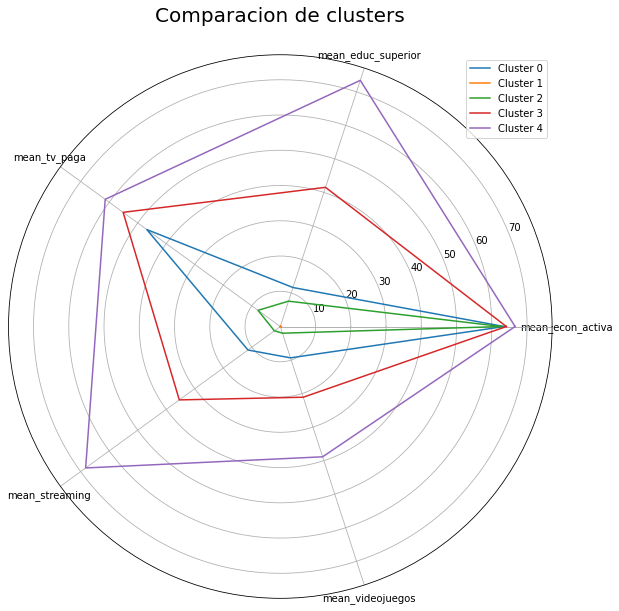

In [23]:
categories = df_clusters.columns[1:-1].values
cluster_0 = df_clusters.where(df_clusters.prediction==0).dropna().values[0][1:-1]
cluster_1 = df_clusters.where(df_clusters.prediction==1).dropna().values[0][1:-1]
cluster_2 = df_clusters.where(df_clusters.prediction==2).dropna().values[0][1:-1]
cluster_3 = df_clusters.where(df_clusters.prediction==3).dropna().values[0][1:-1]
cluster_4 = df_clusters.where(df_clusters.prediction==4).dropna().values[0][1:-1]

cluster_0 = [*cluster_0,cluster_0[0]]
cluster_1 = [*cluster_1,cluster_1[0]]
cluster_2 = [*cluster_2,cluster_2[0]]
cluster_3 = [*cluster_3,cluster_3[0]]
cluster_4 = [*cluster_4,cluster_4[0]]

label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(cluster_0))

plt.figure(figsize=(10, 10))
plt.subplot(polar=True)
plt.plot(label_loc, cluster_0, label='Cluster 0')
plt.plot(label_loc, cluster_1, label='Cluster 1')
plt.plot(label_loc, cluster_2, label='Cluster 2')
plt.plot(label_loc, cluster_3, label='Cluster 3')
plt.plot(label_loc, cluster_4, label='Cluster 4')
plt.title('Comparacion de clusters', size=20)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend()
plt.show()

In [ ]:
#Verde = Cluster 4
#Amarillo = Cluster 3 ; Cluster 0
#Rojo = Cluster 1 ; Cluster 2

Visualización de Datos

In [24]:
df_manzanas = spark.sql("""select ECO1_R as eco_act,
                                  EDU46_R as edu_sup,
                                  VIV82_R as tv_paga,
                                  VIV83_R as stream,
                                  VIV84_R as videoj,
                                  geometry,
                                  prediction 
                           from result_kmeans""").toPandas()
geopandas_df_grid = gpd.GeoDataFrame(df_manzanas, geometry="geometry")
geopandas_df_grid = geopandas_df_grid.set_crs('PROJCS["Mexico_ITRF2008_LCC",GEOGCS["Mexico_ITRF2008",DATUM["Mexico_ITRF2008",SPHEROID["GRS_1980",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP",AUTHORITY["EPSG","9802"]],PARAMETER["Central_Meridian",-102],PARAMETER["Latitude_Of_Origin",12],PARAMETER["False_Easting",2500000],PARAMETER["False_Northing",0],PARAMETER["Standard_Parallel_1",17.5],PARAMETER["Standard_Parallel_2",29.5],PARAMETER["Scale_Factor",1],UNIT["Meter",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","6372"]]')
geopandas_df_grid = geopandas_df_grid.to_crs("EPSG:4326")
#geopandas_df_grid.to_file("/content/drive/MyDrive/GeoBigDataNube2022/resultados/manzanas_kmeans.shp")

In [25]:
import folium

In [26]:
def rank_colormap(gdf):
  if gdf['properties']['prediction'] is 4:
    return 'green'
  if gdf['properties']['prediction'] is 3 or 0:
    return 'yellow'
  if gdf['properties']['prediction'] is 1 or 2:
    return 'red'

In [27]:
m = folium.Map(location=[21.8852562,-102.2915677], zoom_start=14)

folium.GeoJson(data = geopandas_df_grid, name="Estratos",style_function = lambda feature: {
   'fillColor': rank_colormap(feature),
   'color': rank_colormap(feature),
   'weight': '0.5',
   'fill': True,
   'fill_opacity': '1'
}).add_to(m)

In [ ]:
# Despliegue del Mapa
m

Mapa de Densidad de Farmacias

In [29]:
BD_DENUE = spark.read.parquet(f"/content/DENUE_Parquets/01.parquet")
BD_DENUE.createOrReplaceTempView("denue")
BD_DENUE.cache()
BD_DENUE.count()

61645

In [30]:
Influencia_Farmacias = spark.sql("""select 
                                  CVEGEO,
                                  ECO1_R as eco_act,
                                  EDU46_R as edu_sup,
                                  VIV82_R as tv_paga,
                                  VIV83_R as stream,
                                  VIV84_R as videoj,
                                  result_kmeans.geometry,
                                  prediction,
                                  count(*) as n_farma
                           from result_kmeans,
                                denue
                            where denue.codigo_act in ('464111','464112') and
                                  ST_Intersects(result_kmeans.geometry , ST_Buffer(denue.geometry,1500)) 
                            group by CVEGEO, eco_act,edu_sup,tv_paga,stream,videoj,result_kmeans.geometry,prediction """).toPandas()

Influencia_Farmacias_SHP = gpd.GeoDataFrame(Influencia_Farmacias, geometry="geometry")
Influencia_Farmacias_SHP = Influencia_Farmacias_SHP.set_crs('PROJCS["Mexico_ITRF2008_LCC",GEOGCS["Mexico_ITRF2008",DATUM["Mexico_ITRF2008",SPHEROID["GRS_1980",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP",AUTHORITY["EPSG","9802"]],PARAMETER["Central_Meridian",-102],PARAMETER["Latitude_Of_Origin",12],PARAMETER["False_Easting",2500000],PARAMETER["False_Northing",0],PARAMETER["Standard_Parallel_1",17.5],PARAMETER["Standard_Parallel_2",29.5],PARAMETER["Scale_Factor",1],UNIT["Meter",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","6372"]]')
Influencia_Farmacias_SHP = Influencia_Farmacias_SHP.to_crs("EPSG:4326")
#Influencia_Farmacias_SHP.to_file(f"/content/drive/MyDrive/GeoBigDataNube2022/resultados/manzanas_kmeans_farmacias.shp")

In [31]:
Influencia_Farmacias_SHP

,CVEGEO,eco_act,edu_sup,tv_paga,stream,videoj,geometry,prediction,n_farma
0,0100100012687023,59.8,40.7,47.3,34.5,43.6,"POLYGON ((-102.27561 21.85556, -102.27561 21.8...",3,19
1,0100100010962008,59.6,16.8,29.7,17.2,10.9,"POLYGON ((-102.28101 21.85997, -102.28098 21.8...",0,22
2,010010001209A014,50.0,45.0,66.7,0.0,0.0,"POLYGON ((-102.29006 21.86405, -102.28993 21.8...",0,37
3,010010001209A011,54.9,52.3,66.7,38.9,27.8,"POLYGON ((-102.29207 21.86544, -102.29184 21.8...",3,40
4,0100100010905016,68.2,11.5,50.0,21.1,26.3,"POLYGON ((-102.27894 21.87054, -102.27892 21.8...",0,30
...,...,...,...,...,...,...,...,...,...
14640,0100100011034050,71.9,5.4,37.0,5.6,7.4,"POLYGON ((-102.26710 21.81234, -102.26715 21.8...",0,2
14641,0100100011034043,72.4,0.0,25.0,25.0,0.0,"POLYGON ((-102.26668 21.81053, -102.26713 21.8...",0,2
14642,0101100010140005,56.8,0.0,50.0,0.0,0.0,"POLYGON ((-102.26215 22.06117, -102.26247 22.0...",0,3
14643,0100104792742047,50.0,0.0,0.0,0.0,0.0,"POLYGON ((-102.18839 21.82318, -102.18809 21.8...",2,3


In [32]:
m2 = folium.Map(location=[21.8852562,-102.2915677], zoom_start=13)

In [33]:
folium.Choropleth(
    geo_data=Influencia_Farmacias_SHP.to_json(drop_id=True),
    name="Farmacias",
    data=Influencia_Farmacias_SHP,
    columns=["CVEGEO", "n_farma"],
    key_on="feature.properties.CVEGEO",
    fill_color="Spectral",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Farmacias",
).add_to(m2)


In [ ]:
# Display the Choropleth
m2

FIN.